In [93]:
# COSC 4610 Final Project
import pandas as pd
import matplotlib.pyplot as pyplt
get_ipython().run_line_magic('matplotlib', 'inline')

In [105]:
# Read in liquor sales dataset (go make some coffee)
liquor = pd.read_csv('data/Iowa_Liquor_Sales.csv', parse_dates=True, index_col='Invoice/Item Number').sort_values('Date')

C:\Users\5691graupms\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [142]:
# Makes all county names uniform (all caps, no "COUNTY")
def correctCounty(county):
    if isinstance(county, str):
        return county.upper().replace(' COUNTY', '')
    return str(county)

In [107]:
# Trim unnecessary rows
if 'liquor' in locals():
    liquor = liquor.drop('Address', axis=1)
    liquor = liquor.drop('City', axis=1)
    liquor = liquor.drop('Zip Code', axis=1)
    liquor = liquor.drop('County Number', axis=1)
    liquor = liquor.drop('Volume Sold (Gallons)', axis=1)
    liquor = liquor.drop('Pack', axis=1)


In [143]:
# Make county names uniform
liquor['County'] = liquor['County'].apply(correctCounty)
# Remove dollar signs
liquor['Sale (Dollars)'] = liquor['Sale (Dollars)'].str[1:]
liquor['Sale (Dollars)'] = liquor['Sale (Dollars)'].astype(float)
liquor['State Bottle Cost'] = liquor['State Bottle Cost'].str[1:]
liquor['State Bottle Cost'] = liquor['State Bottle Cost'].astype(float)
liquor['State Bottle Retail'] = liquor['State Bottle Retail'].str[1:]
liquor['State Bottle Retail'] = liquor['State Bottle Retail'].astype(float)

In [113]:
earliest = liquor['Date'].min().split('/')
latest = liquor['Date'].max().split('/')
from datetime import date
earliest = date(int(earliest[2]), int(earliest[0]), int(earliest[1]))
latest = date(int(latest[2]), int(latest[0]), int(latest[1]))
delta = (latest - earliest).days / 365
dateRange = str(earliest.strftime('%m/%d/%Y')) + ' to ' + str(latest.strftime('%m/%d/%Y'))
delta

2.9945205479452053

In [144]:
# Read in poverty dataset and trim to median incomes by county
poverty = pd.read_csv('data/est16-ia.csv')
poverty['County'] = poverty['County'].apply(correctCounty)
poverty = poverty.set_index('County')
income = poverty['Median_Household_Income'].sort_values(ascending=False)
#income

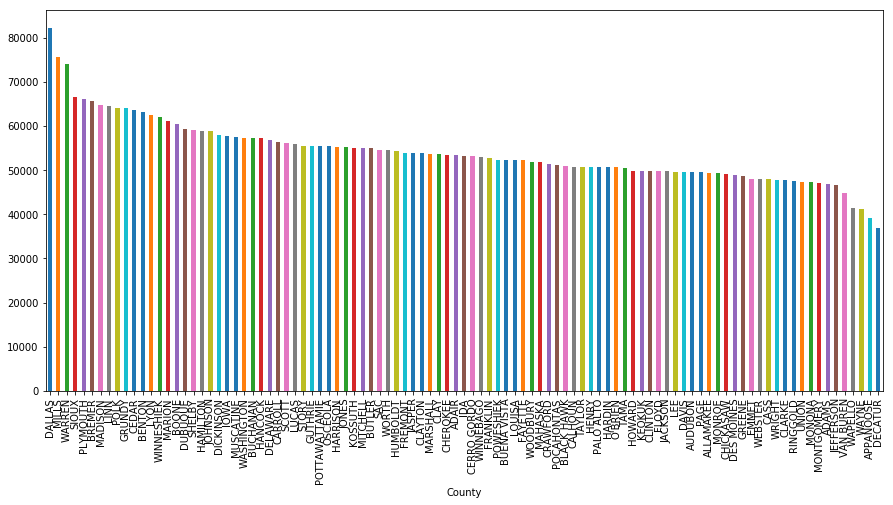

In [115]:
# Plot median household income by county
income.plot(kind='bar', figsize=(15,7))

In [146]:
# The liquor sales have fake? counties, find them
overlap = liquor['County'].isin(income.index)
overlap.value_counts()

True     13199380
False      342518
Name: County, dtype: int64

In [154]:
# Investigate the fake counties
fakeCounties = ~liquor['County'].isin(income.index)
liquor[fakeCounties].County.unique()
# El PASO County is in Colorado so I'm not sure what it is doing in this dataset 

array(['nan', 'EL PASO'], dtype=object)

In [155]:
fakeCountiesmapper = {
    'OBRIEN': "O'BRIEN",
    'BUENA VIST': 'BUENA VISTA',
    'POTTAWATTA': 'POTTAWATTAMIE',
    'CERRO GORD':'CERRO GORDO'
}
liquor = liquor.replace(fakeCountiesmapper)
overlap = liquor['County'].isin(income.index)
overlap.value_counts()

True     13461611
False       80287
Name: County, dtype: int64

In [156]:
# Remove leftover "fake" counties
liquor = liquor[overlap]
liquor['County'].isin(income.index).value_counts()

True    13461611
Name: County, dtype: int64

Text(0,0.5,'Liquor Sales')

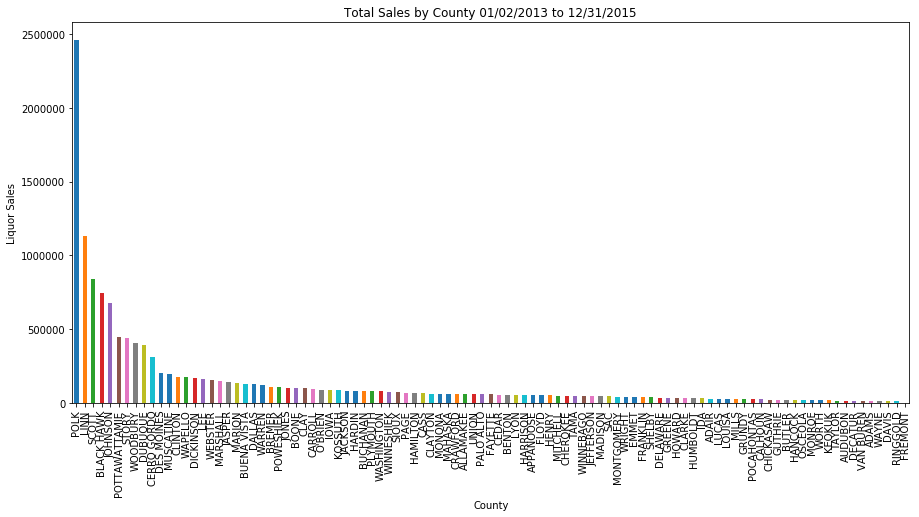

In [157]:
# Count sales by county
pd.set_option("max_rows",105)
countySales = liquor['County'].value_counts()

# Plot that
title = 'Total Sales by County ' + dateRange
plot = countySales.plot(kind='bar', figsize=(15,7), title=title)
plot.set_xlabel('County')
plot.set_ylabel('Liquor Sales')

In [158]:
# Estimate populations by county
populations = (poverty['People_of_All_Ages_in_Poverty'] * 100 / poverty['Percent_of_People_of_All_Ages_in_Poverty']).astype(int).sort_values(ascending=False)
#populations

Text(0,0.5,'Liquor Sales')

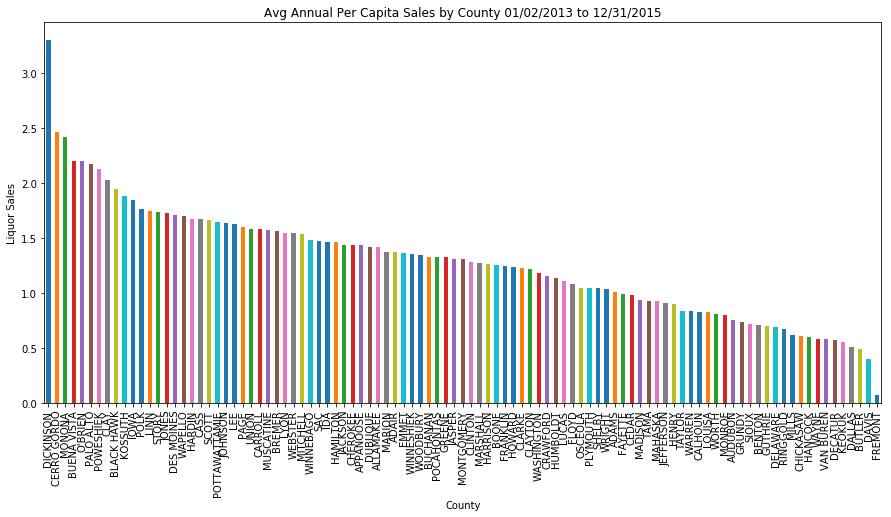

In [159]:
# Calculate and plot liquor sales per capita per year
salesPerCapita = (countySales / populations).sort_values(ascending=False)
salesPerCapita = salesPerCapita.divide(delta)
title = 'Avg Annual Per Capita Sales by County ' + dateRange
plot = salesPerCapita.plot(kind='bar', figsize=(15,7), title=title)
plot.set_xlabel('County')
plot.set_ylabel('Liquor Sales')

In [160]:
# Get the total volume sold by county
def getCountyVolume(county):
    return liquor.loc[liquor['County'] == county, 'Volume Sold (Liters)'].sum()

countyVolumes = pd.Series()
for county in income.index:
    countyVolumes = countyVolumes.set_value(county, getCountyVolume(county))

countyVolumes = countyVolumes.sort_values(ascending=False)

C:\Users\5691graupms\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


Text(0,0.5,'Liquor Volume (L)')

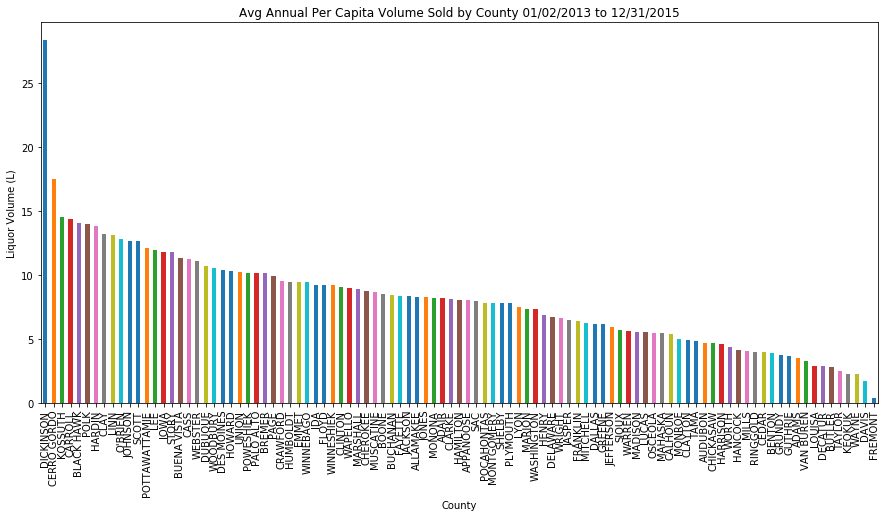

In [161]:
# Plot volume per capita by county per year
volumePerCapita = (countyVolumes / populations).sort_values(ascending=False)
volumePerCapita = volumePerCapita.divide(delta)
title = 'Avg Annual Per Capita Volume Sold by County ' + dateRange
plot = volumePerCapita.plot(kind='bar', figsize=(15,7), title=title)
plot.set_xlabel('County')
plot.set_ylabel('Liquor Volume (L)')

In [162]:
# Get the total spent by county
def getCountySpent(county):
    return liquor.loc[liquor['County'] == county, 'Sale (Dollars)'].sum()

countySpent = pd.Series()
for county in income.index:
    countySpent = countySpent.set_value(county, getCountySpent(county))

countySpent = countySpent.sort_values(ascending=False)

C:\Users\5691graupms\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


Text(0,0.5,'Dollars Spent')

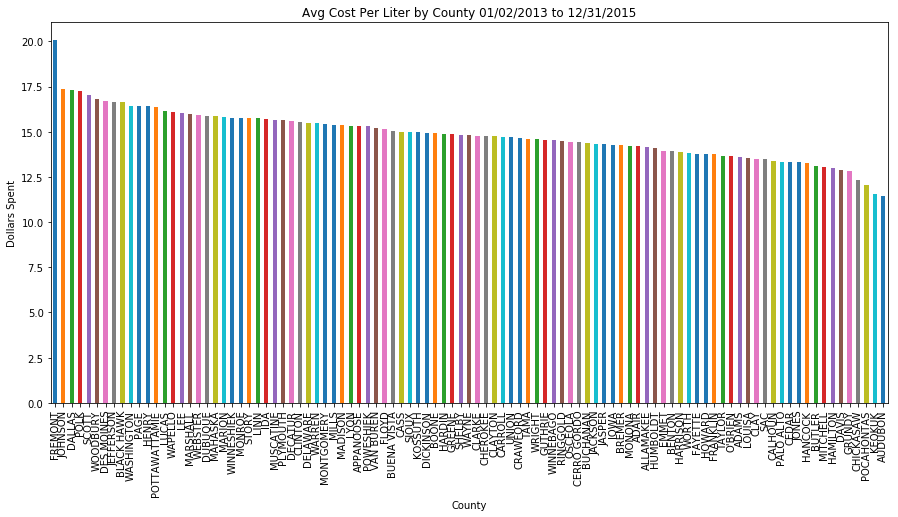

In [163]:
# Plot total spent per capita by county per year
spentPerLiter = (countySpent / countyVolumes).sort_values(ascending=False)
title = 'Avg Cost Per Liter by County ' + dateRange
plot = spentPerLiter.plot(kind='bar', figsize=(15,7), title=title)
plot.set_xlabel('County')
plot.set_ylabel('Dollars Spent')

Text(0,0.5,'Liquor Volume (L)')

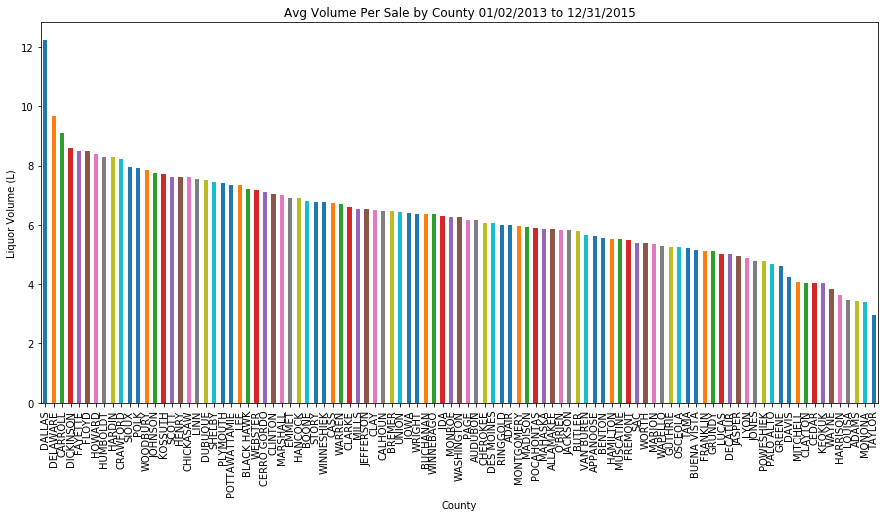

In [164]:
# Volume per sale by county, these numbers seem fishy
volumePerSale = (countyVolumes / countySales).sort_values(ascending=False)
title = 'Avg Volume Per Sale by County ' + dateRange
plot = volumePerSale.plot(kind='bar', figsize=(15,7), title=title)
plot.set_xlabel('County')
plot.set_ylabel('Liquor Volume (L)')

In [ ]:
# This is a waste of time for now
# Get the median income of a county by name
#def getIncome(county):
#    return income.loc[county]

# Apply the income of the county to each sale
#liquor['Median Household Income'] = liquor['County'].apply(getIncome)

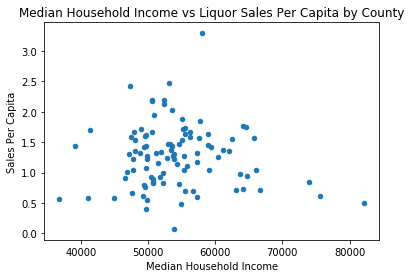

In [165]:
# Plot sales and income
salesIncome = pd.concat([salesPerCapita, income], axis=1)
salesIncome.columns = ['Sales Per Capita', 'Median Household Income']
salesIncome.plot(kind='scatter', y='Sales Per Capita', x='Median Household Income', title='Median Household Income vs Liquor Sales Per Capita by County')

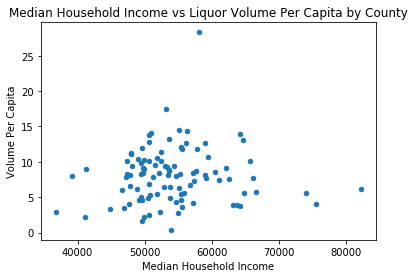

In [166]:
# Plot volume and income
volumeIncome = pd.concat([volumePerCapita, income], axis=1)
volumeIncome.columns = ['Volume Per Capita', 'Median Household Income']
volumeIncome.plot(kind='scatter', y='Volume Per Capita', x='Median Household Income', title='Median Household Income vs Liquor Volume Per Capita by County')

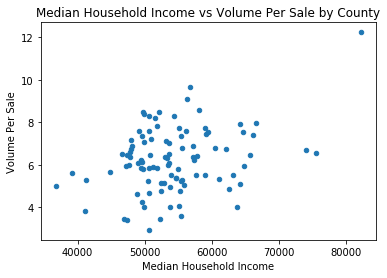

In [167]:
# Plot sale size and income
sizeIncome = pd.concat([volumePerSale, income], axis=1)
sizeIncome.columns = ['Volume Per Sale', 'Median Household Income']
sizeIncome.plot(kind='scatter', y='Volume Per Sale', x='Median Household Income', title='Median Household Income vs Volume Per Sale by County')

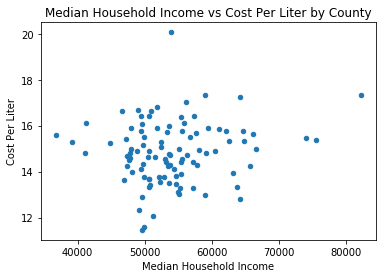

In [168]:
# Plot cost per liter and income
costIncome = pd.concat([spentPerLiter, income], axis=1)
costIncome.columns = ['Cost Per Liter', 'Median Household Income']
costIncome.plot(kind='scatter', y='Cost Per Liter', x='Median Household Income', title='Median Household Income vs Cost Per Liter by County')

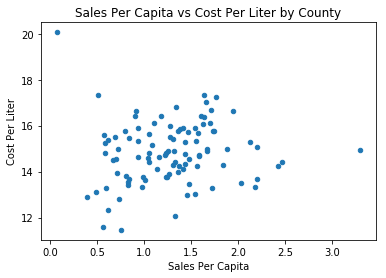

In [169]:
# Plot cpst per liter and sales
costSales = pd.concat([spentPerLiter, salesPerCapita], axis=1)
costSales.columns = ['Cost Per Liter', 'Sales Per Capita']
costSales.plot(kind='scatter', y='Cost Per Liter', x='Sales Per Capita', title='Sales Per Capita vs Cost Per Liter by County')

